<a href="https://colab.research.google.com/github/runnithan03/Deep-Learning-and-Artificial-Intelligence/blob/master/Task%20B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving x_test.csv to x_test (1).csv
Saving xy_train.csv to xy_train (1).csv


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# ==== Load and preprocess data ====
df = pd.read_csv("xy_train.csv")
labels = df.iloc[:, 0].values  # A–F
pixels = df.iloc[:, 1:].values.astype(np.float32)  # Shape: (N, 784)

# Normalise to [0, 1]
pixels /= 255.0

# Reshape into (N, 1, 28, 28)
images = pixels.reshape(-1, 1, 28, 28).astype(np.float32)

# Encode A–F to 0–5
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)

# ==== PyTorch Dataset (Force correct dtypes) ====
class CharacterDataset(Dataset):
    def __init__(self, images, labels):
        self.images = torch.tensor(images, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

# Create Dataset and DataLoader
dataset = CharacterDataset(images, labels_encoded)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

In [ ]:
import torch
import torch.nn as nn

class CVAE(nn.Module):
    def __init__(self, label_dim=6, latent_dim=50):
        super().__init__()
        self.label_dim = label_dim
        self.latent_dim = latent_dim

        # ==== Encoder ====
        self.encoder = nn.Sequential(
            nn.Conv2d(1 + label_dim, 32, 3, stride=2, padding=1),  # → 14×14
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),              # → 7×7
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),             # → 4×4
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(128 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(128 * 4 * 4, latent_dim)

        # ==== Decoder ====
        self.fc_decode = nn.Linear(latent_dim + label_dim, 128 * 4 * 4)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (128, 4, 4)),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),  # 4×4 → 8×8
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),   # 8×8 → 16×16
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, 2, 1),    # 16×16 → 32×32
            nn.ReLU()
        )

        # Final conv to inject labels and output sharp 28×28 images
        self.final_conv = nn.Sequential(
            nn.Conv2d(1 + label_dim, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 1, 3, padding=1),
            nn.Sigmoid()
        )

    def encode(self, x, y):
        y = y.view(-1, self.label_dim, 1, 1).expand(-1, -1, 28, 28)
        x = torch.cat([x, y], dim=1)
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, y):
        z = torch.cat([z, y], dim=1)
        h = self.fc_decode(z)
        x = self.decoder(h)  # → [B, 1, 32, 32]

        # Inject label into final spatial map
        y_expanded = y.view(-1, self.label_dim, 1, 1).expand(-1, self.label_dim, 32, 32)
        x = torch.cat([x, y_expanded], dim=1)
        x = self.final_conv(x)
        return x[:, :, 2:-2, 2:-2]  # Crop 32×32 → 28×28

    def forward(self, x, y):
        mu, logvar = self.encode(x, y)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z, y)
        return recon, mu, logvar


In [ ]:
# ==== Training ====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CVAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

epochs = 1000
stage = 0  # for tracking steps across all epochs

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for x, y in loader:
        x = x.to(device).float()
        y = y.to(device)
        x = torch.clamp(x, 0.0, 1.0)

        y_onehot = F.one_hot(y, num_classes=6).float()
        recon, mu, logvar = model(x, y_onehot)
        loss = loss_function(recon, x, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        stage += 1

        if stage % 100 == 0:
            print(f"Stage {stage}, Batch Loss: {loss.item():.2f}")

    print(f"Epoch {epoch + 1}, Avg Loss: {total_loss / len(dataset):.2f}")

Epoch 1, Avg Loss: 174.16
Epoch 2, Avg Loss: 174.19
Epoch 3, Avg Loss: 174.14
Epoch 4, Avg Loss: 174.11
Epoch 5, Avg Loss: 174.16
Epoch 6, Avg Loss: 173.84
Epoch 7, Avg Loss: 173.85
Epoch 8, Avg Loss: 173.81
Epoch 9, Avg Loss: 173.96
Epoch 10, Avg Loss: 174.06
Epoch 11, Avg Loss: 174.03
Epoch 12, Avg Loss: 173.98
Stage 100, Batch Loss: 11283.24
Epoch 13, Avg Loss: 173.88
Epoch 14, Avg Loss: 173.63
Epoch 15, Avg Loss: 173.64
Epoch 16, Avg Loss: 173.77
Epoch 17, Avg Loss: 173.61
Epoch 18, Avg Loss: 173.79
Epoch 19, Avg Loss: 173.77
Epoch 20, Avg Loss: 173.67
Epoch 21, Avg Loss: 173.70
Epoch 22, Avg Loss: 173.69
Epoch 23, Avg Loss: 173.82
Epoch 24, Avg Loss: 173.58
Stage 200, Batch Loss: 8828.99
Epoch 25, Avg Loss: 173.56
Epoch 26, Avg Loss: 173.57
Epoch 27, Avg Loss: 173.60
Epoch 28, Avg Loss: 173.94
Epoch 29, Avg Loss: 173.88
Epoch 30, Avg Loss: 173.61
Epoch 31, Avg Loss: 173.62
Epoch 32, Avg Loss: 173.49
Epoch 33, Avg Loss: 173.67
Epoch 34, Avg Loss: 173.61
Epoch 35, Avg Loss: 173.88
E

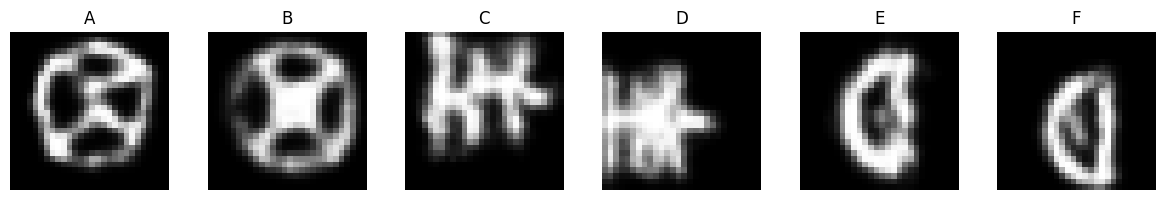

In [ ]:
# ==== Sampling and Visualization ====
model.eval()
with torch.no_grad():
    z = torch.randn(6, 50).to(device)  # updated for latent_dim = 50
    y = torch.arange(6)
    y_onehot = F.one_hot(y, num_classes=6).float().to(device)
    samples = model.decode(z, y_onehot).cpu()

    fig, axes = plt.subplots(1, 6, figsize=(12, 2))
    for i, ax in enumerate(axes):
        ax.imshow(samples[i][0], cmap="gray")
        ax.axis("off")
        ax.set_title(le.inverse_transform([i])[0])
    plt.tight_layout()
    plt.savefig("samples_per_class.png")
    plt.show()

In [ ]:
import os
import zipfile
from torchvision.utils import save_image
from tqdm import tqdm

# Ensure model is in eval mode
model.eval()

# Create base folder
output_dir = "vae_samples"
os.makedirs(output_dir, exist_ok=True)

# Generate 500 images per class (0–5)
images_per_class = 500
latent_dim = 50

with torch.no_grad():
    for class_idx in tqdm(range(6), desc="Generating images"):
        class_label = le.inverse_transform([class_idx])[0]  # 'A'–'F'
        class_folder = os.path.join(output_dir, class_label)
        os.makedirs(class_folder, exist_ok=True)

        y = torch.full((images_per_class,), class_idx, dtype=torch.long)
        y_onehot = F.one_hot(y, num_classes=6).float().to(device)
        z = torch.randn(images_per_class, latent_dim).to(device)
        generated = model.decode(z, y_onehot).cpu()  # [500, 1, 28, 28]

        for i in range(images_per_class):
            save_path = os.path.join(class_folder, f"{class_label}_{i+1:03d}.png")
            save_image(generated[i], save_path)

# === Zip the folder ===
zip_path = "vae_character_samples.zip"
with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk(output_dir):
        for file in files:
            file_path = os.path.join(root, file)
            arcname = os.path.relpath(file_path, output_dir)
            zipf.write(file_path, arcname)

print(f"\n✅ All done: ZIP saved as {zip_path}")


Generating images: 100%|██████████| 6/6 [00:06<00:00,  1.12s/it]



✅ All done: ZIP saved as vae_character_samples.zip


In [ ]:
from google.colab import files
files.download(zip_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>